# Analysis of microarry data from patients with myotonic dystrophy.

# Pre-process & Normalise data

In [1]:
# First check if all CEL files are present. We expect data from 35 patients

import os, os.path

CEL_LOCATION = os.path.join("CELfiles", "blood")

CELFILES = os.listdir(CEL_LOCATION)
CELFILES = [file for file in CELFILES if file[-4:] == ".CEL"]

assert(len(CELFILES) == 35)

In [2]:
# Carry out RMA normalisation on all CEL files. Write output to corefile This step takes a few minutes

import utils
corefile =  os.path.join(CEL_LOCATION, "core")
try:
    with open(corefile, "rb") as f:
        print("corefile exists")
except FileNotFoundError:
    utils.executeNotebook("normalise.ipynb", CEL_LOCATION)
    print("corefile created")

corefile exists


In [3]:
# Retrieve HUAX IDs from CEL files

import sys
import re
import json

def processCELFile(basePath, lastPath):
    relPath = os.path.join(basePath, lastPath)
    result = ""
    with open(relPath, "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines[0:20]):
            try:
                result = re.search(b"(\d)*HUEX1A11", line).group()
                
            except AttributeError:
                pass
    return result.decode("utf-8")
CELTOHUAX = {}
for celfile in CELFILES:
    CELTOHUAX[celfile] = str(processCELFile(CEL_LOCATION, celfile))

In [4]:
# Swap IDs from CEL to HUEX
filename = os.path.join(CEL_LOCATION, "core")
with open(filename, "r") as f:
    lines = f.readlines()
    swapped = [CELTOHUAX[line] for line in lines[0].rstrip().split("\t")[1:]]

swappedLine = "IDs\t" + "\t".join(swapped)
with open("normalisedFirstLine", "w") as f:
    f.write(swappedLine)
    f.write("\n")

In [5]:
# finish off the job using a bash script and a complicated python script, which pulls data from all over the place.

import subprocess
completed = subprocess.run("./analyseBlood.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#print("stdout")
#print(completed.stdout.decode("utf-8"))
#print("stderr")
#print(completed.stderr.decode("utf-8"))

### pre-processing & normalisation finished. File `cleaned` written to hard drive in current working directory.

# Analyse the data using Numpy

In [6]:
import numpy as np
import scipy.stats
#./analyseWithNumpy.py cleaned
#./generatePermuted.sh
#./analyseWithNumpy.py permuted
#./generateRandomData.py > randomData
#./analyseWithNumpy.py randomData
#./generateRandomTranscriptionFactors.py > randomTranscriptionFactors
#./analyseWithNumpy.py randomTranscriptionFactors
#./generateIndividualTranscriptionFactors.py > randomIndividualTranscriptionFactors
#./analyseWithNumpy.py randomIndividualTranscriptionFactors
#./analysePermuteWithNumpy.py cleaned
CLEANED = "cleaned"
with open(CLEANED) as f:
    rowID = None
    skipCount = 0
    while rowID != "Affymetrix":
        line = f.readline().rstrip().split()
        skipCount += 1
        rowID = line[0]
        if rowID == "IDs":
            columns = range(len(line))[1:]
            ids = line[1:]
        if rowID == "ModalAllele":
            MODAL_ALLELE = [int(i) for i in line[1:]]

with open(CLEANED) as f:
    CLEANED =  np.loadtxt(f, delimiter="\t", skiprows=skipCount, usecols=columns)

RESIDUALS = np.zeros_like(CLEANED)

rowNo, columnNo = CLEANED.shape

for i in range(rowNo):
    slope, intercept, _, _, _ = scipy.stats.linregress(MODAL_ALLELE, list(CLEANED[i]))
    expected = [slope * value + intercept for value in MODAL_ALLELE]
    residuals = [actual - expected for actual, expected in zip(CLEANED[i], expected)]
    for j, residual in enumerate(residuals):
        RESIDUALS[i][j] = residual

RESIDUALS_PVALUES = []
for i in range(columnNo):
    p_value = scipy.stats.ttest_1samp(RESIDUALS[:,i], 0)[1]
    RESIDUALS_PVALUES.append(p_value)

_ = CLEANED # RMA normalised Affymetrix data
_ = RESIDUALS # Residuals computed from MODAL_ALLELE
_ = MODAL_ALLELE # Modal allele length

## Analysing primary dataset with `numpy` finished. Variables `CLEANED`, `RESIDUALS` and `RESIDUALS_PVALUES` and `MODAL_ALLELE` are exposed.

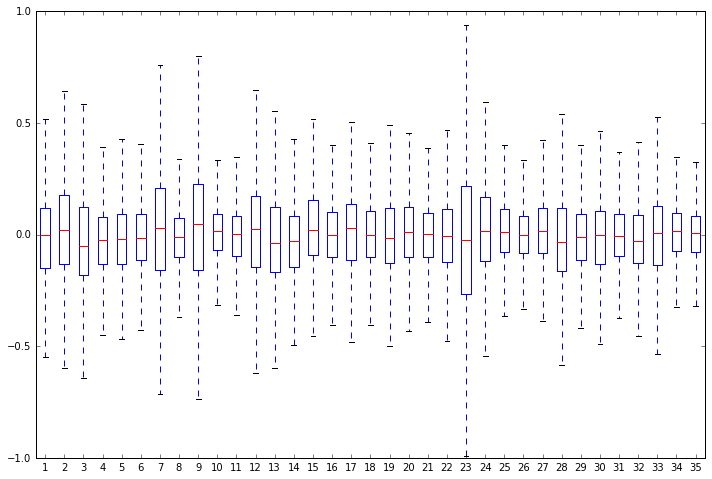

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

data_to_plot = [[RESIDUALS[:, i]] for i in range(columnNo)]
fig = plt.figure()
plt.boxplot(data_to_plot, showfliers=False)
plt.show()


### Boxplot of residuals

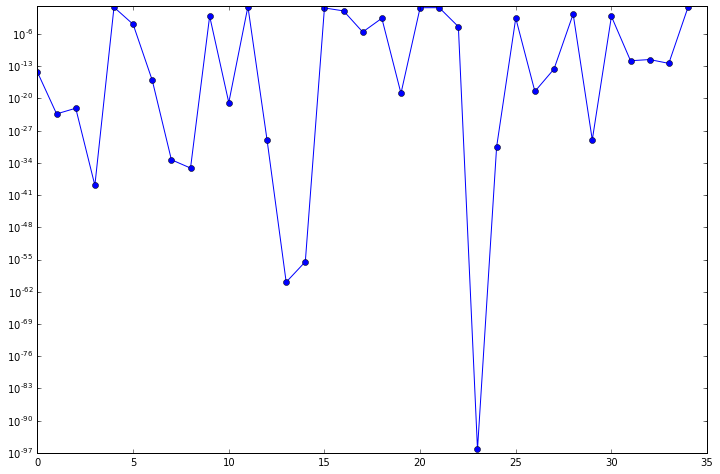

In [8]:
import math
fig = plt.figure()
plt.semilogy(range(len(RESIDUALS_PVALUES)), RESIDUALS_PVALUES, marker='o')
plt.show()

### y-axis log graph of p-values

## Are ISEs a failure of normalisation?